In [1]:
import glworia.load_interp
from glworia.load_interp import *
import bilby_scripts.waveform
from bilby_scripts.waveform import *
import bilby

In [2]:
import configparser
import matplotlib.pyplot as plt

In [3]:
from importlib import reload

In [4]:
reload(glworia.load_interp)
from glworia.load_interp import *
reload(bilby_scripts.waveform)
from bilby_scripts.waveform import *

In [5]:
import matplotlib.pyplot as plt

In [6]:
lp_name = 'xc'
lens_model_name = 'CIS'
lp_low, lp_hi = 0., 1.

settings = {
    'lens_param_name': lp_name,
    'y_low': 0.1,
    'y_high': 5.0,
    'lp_low': lp_low,
    'lp_high': lp_hi,
    'N_grid': 101,
    'N_grid_strong': 201,
    'N_crit': 201,
    'N': 200,
    'lens_model_name': lens_model_name,

    'T0_max': 1000,

    'y_low_im': 0.1,
    'y_high_im': 5.0,
    'lp_low_im': lp_low,
    'lp_high_im': lp_hi,
    'N_grid_im': 401,
    'N_crit_im': 401,

    'crit_param_low': lp_low,
    'crit_param_high': lp_hi
}

In [7]:
interpolators = load_interpolators('./interpolation', **settings)

In [27]:
interpolators = load_interpolators('./interpolation', **settings)
w_interp = np.linspace(0.001, 1e4, 10**6)
y_interp = 0.3
lp_interp = 0.02

y_interp_2 = 0.791309
lp_interp_2 = 0.252796

In [28]:
F, F_g, partitions, T_im_hi, T_im, mu_im, u0, u1, u2, u3, um, w1, F1, w2, F2 = F_interp(w_interp, y_interp, lp_interp, interpolators, settings,
             return_geom = True, 
             )
out = F_interp(w_interp, y_interp_2, lp_interp_2, interpolators, settings,
             return_geom = True, 
             )
F_2 = out[0]

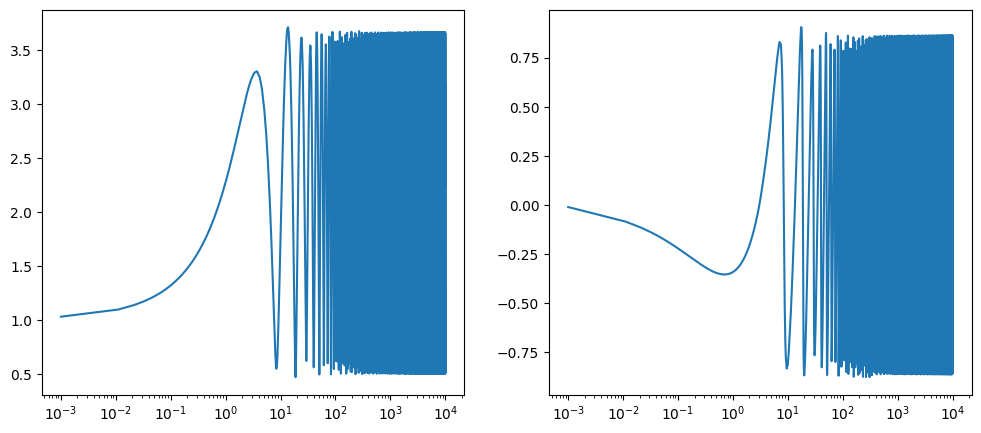

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].semilogx(w_interp, np.abs(F))
# axs[0].semilogx(w_interp, np.abs(F_g), alpha = 0.5)
axs[1].semilogx(w_interp, np.angle(F))

In [80]:
duration = 4.0
sampling_frequency = 2048.0

waveform_arguments = dict(
    waveform_approximant="IMRPhenomXAS",
    reference_frequency=50.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

waveform_arguments_lens = waveform_arguments.copy()

interpolators = load_interpolators('./interpolation', **settings)
F_interp_loaded = lambda w, y, kappa: F_interp(w, y, kappa, interpolators, settings)

# Fixed arguments passed into the source model
waveform_arguments.update(F_interp = F_interp_loaded)

waveform_generator_lensed = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=lal_binary_black_hole_lensed,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

16:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby_scripts.waveform.lal_binary_black_hole_lensed
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [87]:
wf_param_dict = dict(
    mass_1=30.0,
    mass_2=30.0,
    a_1=0.,
    a_2=0.,
    tilt_1=0.,
    tilt_2=0.,
    phi_12=0.,
    phi_jl=0.,
    theta_jn=np.pi/3,
    psi=np.pi/2,
    phase=np.pi/2,
    geocent_time=1126259642.413,
    luminosity_distance=500,
    ra=1.375,
    dec=-1.2108,
)

lens_max_like = wf_param_dict.copy()
lens_max_like['MLz'] = 390.529249
lens_max_like['y'] = 0.791309
lens_max_like['lp'] = 0.252796
lens_max_like['luminosity_distance'] = 602.591507

lens_injection_params = lens_max_like.copy()
lens_injection_params['MLz'] = 100
lens_injection_params['y'] = 2.
lens_injection_params['lp'] = 0.2
lens_injection_params['luminosity_distance'] = 500


In [88]:
def get_strain(injection_parameters, ifos, noise = True):
    if noise:
        ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=sampling_frequency,
            duration=duration,
            start_time=injection_parameters["geocent_time"] - 2,
        )
    else:
        ifos.set_strain_data_from_zero_noise(
            sampling_frequency=sampling_frequency,
            duration=duration,
            start_time=injection_parameters["geocent_time"] - 2,
        )
    ifos.inject_signal(
        waveform_generator=waveform_generator_lensed, parameters=injection_parameters
    )

In [89]:
np.random.seed(1234)
noise = False
ifos_inject = bilby.gw.detector.InterferometerList(["H1", "L1"])
get_strain(lens_injection_params, ifos_inject, noise = noise)
ifos_max_like = bilby.gw.detector.InterferometerList(["H1", "L1"])
get_strain(lens_max_like, ifos_max_like, noise = noise)

16:03 bilby INFO    : Injected signal in H1:
16:03 bilby INFO    :   optimal SNR = 29.89
16:03 bilby INFO    :   matched filter SNR = 29.89-0.00j
16:03 bilby INFO    :   mass_1 = 30.0
16:03 bilby INFO    :   mass_2 = 30.0
16:03 bilby INFO    :   a_1 = 0.0
16:03 bilby INFO    :   a_2 = 0.0
16:03 bilby INFO    :   tilt_1 = 0.0
16:03 bilby INFO    :   tilt_2 = 0.0
16:03 bilby INFO    :   phi_12 = 0.0
16:03 bilby INFO    :   phi_jl = 0.0
16:03 bilby INFO    :   theta_jn = 1.0471975511965976
16:03 bilby INFO    :   psi = 1.5707963267948966
16:03 bilby INFO    :   phase = 1.5707963267948966
16:03 bilby INFO    :   geocent_time = 1126259642.413
16:03 bilby INFO    :   luminosity_distance = 500
16:03 bilby INFO    :   ra = 1.375
16:03 bilby INFO    :   dec = -1.2108
16:03 bilby INFO    :   MLz = 100
16:03 bilby INFO    :   y = 2.0
16:03 bilby INFO    :   lp = 0.2
16:03 bilby INFO    : Injected signal in L1:
16:03 bilby INFO    :   optimal SNR = 25.91
16:03 bilby INFO    :   matched filter SNR 

16:03 bilby INFO    : Injected signal in H1:
16:03 bilby INFO    :   optimal SNR = 31.06
16:03 bilby INFO    :   matched filter SNR = 31.06-0.00j
16:03 bilby INFO    :   mass_1 = 30.0
16:03 bilby INFO    :   mass_2 = 30.0
16:03 bilby INFO    :   a_1 = 0.0
16:03 bilby INFO    :   a_2 = 0.0
16:03 bilby INFO    :   tilt_1 = 0.0
16:03 bilby INFO    :   tilt_2 = 0.0
16:03 bilby INFO    :   phi_12 = 0.0
16:03 bilby INFO    :   phi_jl = 0.0
16:03 bilby INFO    :   theta_jn = 1.0471975511965976
16:03 bilby INFO    :   psi = 1.5707963267948966
16:03 bilby INFO    :   phase = 1.5707963267948966
16:03 bilby INFO    :   geocent_time = 1126259642.413
16:03 bilby INFO    :   luminosity_distance = 602.591507
16:03 bilby INFO    :   ra = 1.375
16:03 bilby INFO    :   dec = -1.2108
16:03 bilby INFO    :   MLz = 390.529249
16:03 bilby INFO    :   y = 0.791309
16:03 bilby INFO    :   lp = 0.252796
16:03 bilby INFO    : Injected signal in L1:
16:03 bilby INFO    :   optimal SNR = 26.92
16:03 bilby INFO   

(1e-28, 9.15221804820329e-23)

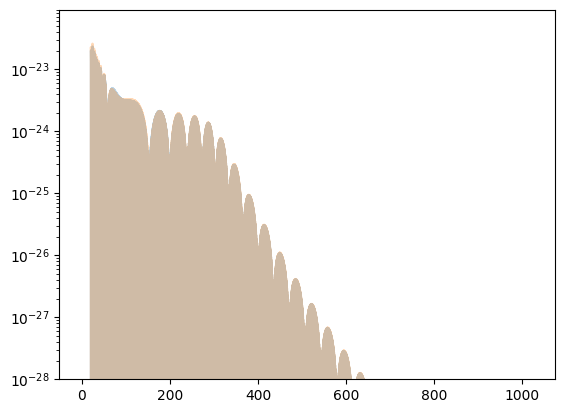

In [94]:
plt.semilogy(ifos_inject.frequency_array, np.imag(ifos_inject[0].strain_data.frequency_domain_strain), alpha = 0.3)
plt.semilogy(ifos_max_like.frequency_array, np.imag(ifos_max_like[0].strain_data.frequency_domain_strain), alpha = 0.3)
plt.ylim(1e-28, None)

In [54]:
ifos[0].strain_data.frequency_domain_strain

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
        2.38689093e-27-1.11896926e-27j, -2.34709784e-27+1.16320911e-27j,
        2.30661681e-27-1.20629952e-27j])

In [21]:
strain_dict = waveform_generator.frequency_domain_strain(wf_param_dict)
strain_dict_2 = waveform_generator.frequency_domain_strain(wf_param_dict_2)

In [22]:
freq = waveform_generator.frequency_array
Mtow = 8*np.pi*G/c**3*Msun
MLz = 100
freq_w = w_interp/MLz/Mtow

In [29]:
F_int = np.interp(freq, freq_w, F)
F_int_2 = np.interp(freq, freq_w, F_2)

In [24]:
from bilby.gw.detector import PowerSpectralDensity
psd = PowerSpectralDensity(asd_file='aLIGO_O4_high_asd.txt')

In [25]:
from bilby.gw.utils import inner_product

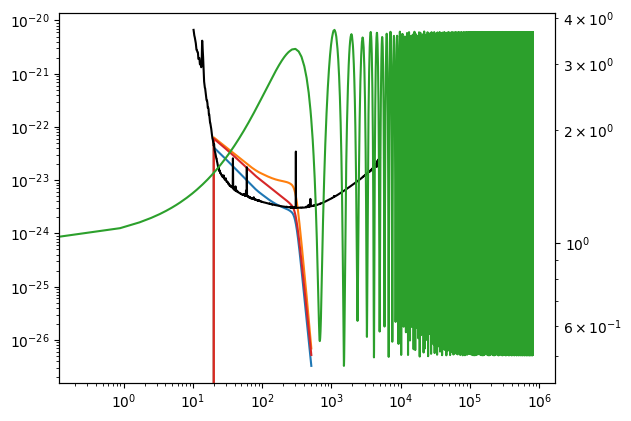

In [30]:
fig, ax = plt.subplots()
ax.loglog(freq, np.abs(strain_dict['plus']))
ax2 = ax.twinx()
ax2.loglog(freq_w, np.abs(F), color = 'C2')
ax.loglog(freq, np.abs(strain_dict['plus']*F_int))
ax.loglog(freq, np.abs(strain_dict_2['plus']*F_int_2), color = 'C3')

ax.loglog(psd.frequency_array, np.sqrt(psd.psd_array), c = "k")

In [55]:
match_hL_h = inner_product(strain_dict['plus']*F_int, strain_dict['plus'], freq, psd)
match_hL_hL = inner_product(strain_dict['plus']*F_int, strain_dict['plus']*F_int, freq, psd)
match_h_h = inner_product(strain_dict['plus'], strain_dict['plus'], freq, psd)
print(1-match_hL_h/np.sqrt(match_h_h*match_hL_hL))

0.06367762064905413


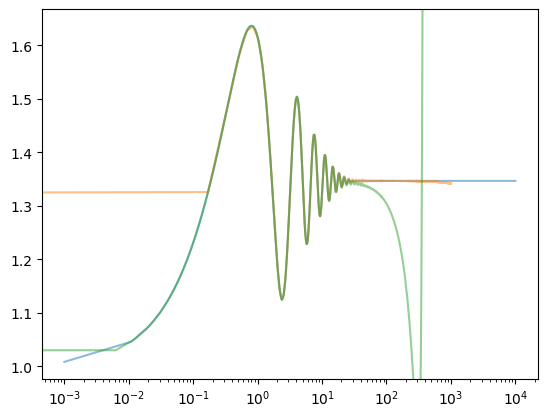

In [97]:
# cut at 1e3

F1_cut = F1[w1 < 1e3]
w1_cut = w1[w1 < 1e3]
F2_cut = F2[w2 < 1e3]
w2_cut = w2[w2 < 1e3]

plt.semilogx(w_interp, np.abs(F), alpha = 0.5)
plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())

plt.semilogx(w1_cut, np.abs(F1_cut), alpha = 0.5)
plt.semilogx(w2_cut, np.abs(F2_cut), alpha = 0.5)

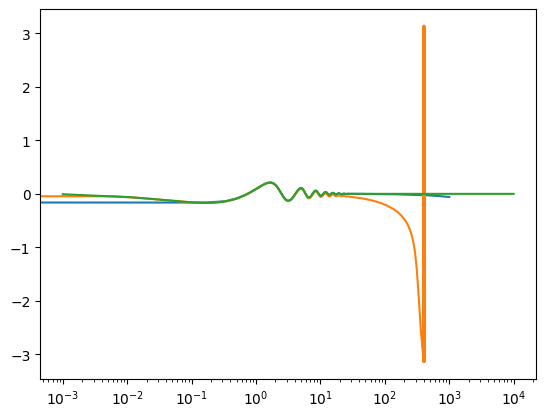

In [98]:
plt.semilogx(w1_cut, np.angle(F1_cut))
plt.semilogx(w2_cut, np.angle(F2_cut))
plt.semilogx(w_interp, np.angle(F))

# plt.ylim(1, 2)

In [54]:
F_scale = np.max(np.abs(F-1))/2

(0.001, 10.0)

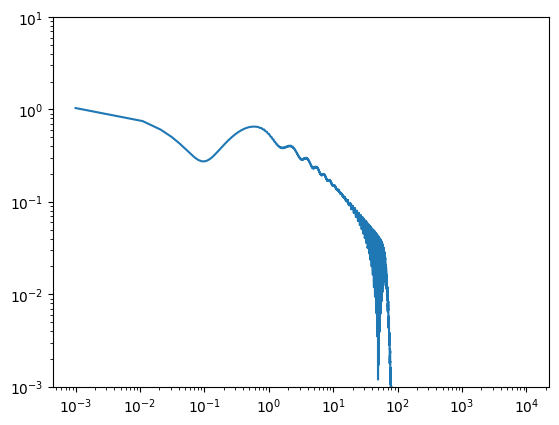

In [55]:
fig, ax = plt.subplots()
ax.loglog(w_interp, np.abs((F-F_g)/F_scale))
ax.set_ylim(1e-3, 1e1)